In [27]:
import h5py
import mdtraj as md
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

a_to_nm = 0.1

### Loading Ground Truth Trajectory and Boltz predictions.

In [28]:
gt_topology = md.load('/data2/scratch/group_scratch/cg/datasets/chignolin/chignolin.pdb').topology

with h5py.File('/data2/scratch/group_scratch/cg/datasets/chignolin/chignolin_traj_all.hdf5', 'r') as file:
    if "positions" not in file.keys():
        raise ValueError("No positions in file")
    positions = file["positions"][:]
    frames_to_save = np.arange(positions.shape[0])
    gt_trajectory = md.Trajectory(
        positions * a_to_nm, # Ground truth positions are in angstroms.
        gt_topology
    )

In [29]:
# Creating a mdtraj.Trajectory object out of Boltz predictions.

# Default temperature
# PRED_DIR = '/home/ethanz/boltz-likelihoods/boltz_results_chignolin/predictions/chignolin'
# Low temperature
# PRED_DIR = '/home/ethanz/boltz-likelihoods/boltz_results_chignolin_lowT/predictions/chignolin_lowT'
# High temperature
PRED_DIR = '/home/ethanz/boltz-likelihoods/boltz_results_chignolin_highT/predictions/chignolin_highT'

pred_structs = [
    os.path.join(PRED_DIR, file) for file in os.listdir(PRED_DIR)
    if file[-4:] == '.cif'
    ]

traj_coordinates = []
for file in tqdm(sorted(pred_structs)):
    temp = md.load(os.path.join(PRED_DIR, file)) # cifs are in angstroms.
    traj_coordinates.append(temp.xyz) # These are all now in nanometers! No more conversion needed.

traj_coordinates = np.array(traj_coordinates).squeeze(1) # (n_preds, n_atoms, 3) 
boltz_topology = md.load(pred_structs[0]).topology
boltz_trajectory = md.Trajectory(traj_coordinates, boltz_topology)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:19<00:00, 254.91it/s]


In [30]:
# Gut-checking conversions.
print(np.linalg.norm(boltz_trajectory.xyz[0][0] - boltz_trajectory.xyz[0][1]))
print(np.linalg.norm(gt_trajectory.xyz[0][0] - gt_trajectory.xyz[0][1]))

0.14655483
0.10900013


### Using pre-computed tICA coordinates to plot free energies.

In [31]:
# Loading tICA coordinates computed using the GT trajectory.
tica_eigenvector_chignolin = np.load(
    "/data2/scratch/group_scratch/cg/datasets/chignolin/tica_eigenvectors.npy"
)
tica_mean_chignolin = np.load(
    "/data2/scratch/group_scratch/cg/datasets/chignolin/tica_mean.npy"
)

In [32]:
def get_chignolin_reaction_coordinates(
    top, 
    r_coordinates,
    mean, 
    eigenvectors,
    device="cuda:0"
):
    """
    Parameters
    ----------
    top : mdtraj.Topology object
        Topology of the trajectory.
    r_coordinates : np.array of shape (frames, n_atoms, 3)
        Coordinate array of the trajectory.

    Returns
    -------
    all_projections_sub : torch.tensor of shape (frames, 2)
        tICA coordinate values for every frame.
    """
    traj = md.Trajectory(r_coordinates, top).atom_slice(top.select("name CA"))
    distance_indeces = [[i, j] for i in range(traj.n_atoms) 
                    for j in range(i + 1, traj.n_atoms)]
    all_distances = md.compute_distances(traj, distance_indeces)
    all_projections_sub = ((all_distances - mean)  @ eigenvectors)[:, :2]
    return torch.tensor(all_projections_sub)

torch.Size([5000, 2])
torch.Size([1229000, 2])


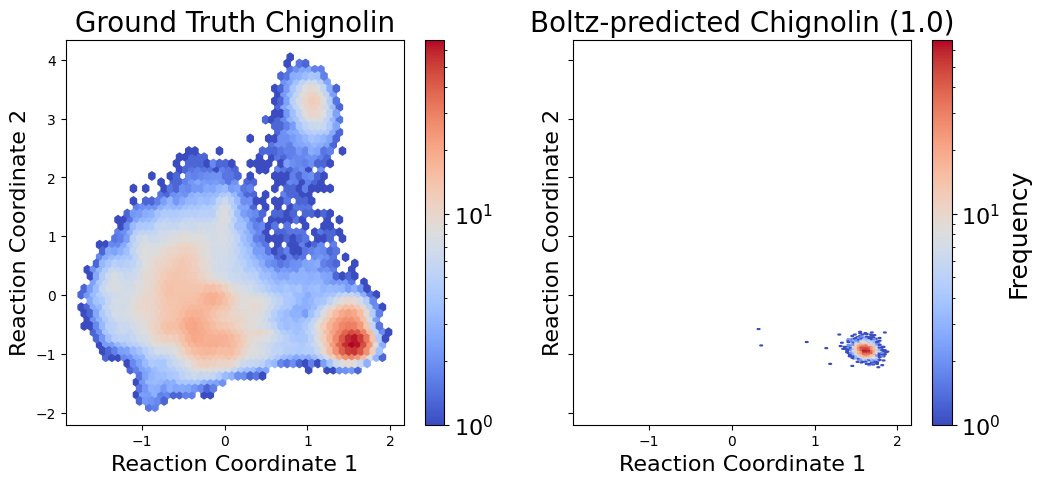

In [33]:
boltz_rcs = get_chignolin_reaction_coordinates(
    boltz_trajectory.topology, 
    boltz_trajectory.xyz,
    tica_mean_chignolin,
    tica_eigenvector_chignolin,
    device="cuda:0")
print(boltz_rcs.shape)

gt_rcs = get_chignolin_reaction_coordinates(
    gt_trajectory.topology, 
    gt_trajectory.xyz,
    tica_mean_chignolin,
    tica_eigenvector_chignolin,
    device="cuda:0")
print(gt_rcs.shape)

fig, ax = plt.subplots(1,2, figsize=(12, 5), sharex=True, sharey=True)
# Create hexbin plot
hb = ax[0].hexbin(gt_rcs[:,0], gt_rcs[:,1], gridsize=50, cmap='coolwarm', norm=mcolors.LogNorm())
ax[0].set_title("Ground Truth Chignolin", fontsize=20)
ax[0].set_xlabel("Reaction Coordinate 1", fontsize=16)
ax[0].set_ylabel("Reaction Coordinate 2", fontsize=16)

# Create hexbin plot
hb = ax[1].hexbin(boltz_rcs[:,0], boltz_rcs[:,1], gridsize=50, cmap='coolwarm', norm=mcolors.LogNorm())
ax[1].set_title("Boltz-predicted Chignolin (1.0)", fontsize=20)
ax[1].set_xlabel("Reaction Coordinate 1", fontsize=16)
ax[1].set_ylabel("Reaction Coordinate 2", fontsize=16)

# Add colorbar
cb = fig.colorbar(hb, ax=ax[0])
cb.ax.tick_params(labelsize=16)  # Set colorbar tick label size
cb = fig.colorbar(hb, ax=ax[1])
cb.ax.tick_params(labelsize=16)  # Set colorbar tick label size
cb.set_label('Frequency', fontsize=18) 

# Set both subplots' axes limits to be the same.
# xlim = (0, 10)
# ylim = (-5, 5)

# for a in ax:
#     a.set_xlim(xlim)
#     a.set_ylim(ylim)

plt.savefig('/home/ethanz/figs/chignolin_1.0.jpg')
plt.show()